<a href="https://colab.research.google.com/github/kritikaberry/TAI-Hackathon-Riverhouse-Problem5/blob/users%2Fkritikaberry%2FmitIncidents/MIT_Incidents_DB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MIT (Part of CODE DEMO) with Incidents + Reports

This script automatically scrapes, downloads, and extracts the latest AI Incident Database snapshot to load the core incident, report, and classification data into Pandas DataFrames for analysis.

In [65]:
# 1) Install deps
!pip -q install beautifulsoup4 lxml

import re, tarfile
from pathlib import Path
import requests
import pandas as pd
from bs4 import BeautifulSoup

SNAPSHOT_PAGE = "https://incidentdatabase.ai/research/snapshots/"
OUT_DIR = Path("/content/aiid_snapshot")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# 2) Fetch snapshot page and find all .tar.bz2 links
html = requests.get(SNAPSHOT_PAGE, timeout=60).text
soup = BeautifulSoup(html, "lxml")

links = []
for a in soup.select("a[href]"):
    href = a["href"]
    if ".tar.bz2" in href:
        if href.startswith("/"):
            href = "https://incidentdatabase.ai" + href
        links.append(href)

if not links:
    raise RuntimeError("No .tar.bz2 links found on the snapshots page. Page structure may have changed.")

# 3) Pick the latest by timestamp in filename (backup-YYYYMMDDHHMMSS.tar.bz2)
def ts_key(url):
    m = re.search(r"backup-(\d{14})\.tar\.bz2", url)
    return m.group(1) if m else ""

latest_url = sorted(links, key=ts_key)[-1]
print("Latest snapshot URL:", latest_url)

# 4) Download
tar_path = Path("/content") / latest_url.split("/")[-1]
with requests.get(latest_url, stream=True, timeout=300) as r:
    r.raise_for_status()
    with open(tar_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024*1024):
            if chunk:
                f.write(chunk)

print("Downloaded to:", tar_path)

# 5) Extract
with tarfile.open(tar_path, "r:bz2") as tar:
    tar.extractall(OUT_DIR)

print("Extracted to:", OUT_DIR)

# 6) Find + assign the three CSVs to three DataFrames
def find_one(pattern: str) -> Path:
    matches = list(OUT_DIR.rglob(pattern))
    if not matches:
        raise FileNotFoundError(f"Could not find file matching {pattern} under {OUT_DIR}")
    return matches[0]

incidents_path = find_one("*incidents*.csv")
reports_path   = find_one("*reports*.csv")
mit_path       = find_one("*MIT*.csv")   # usually classifications_MIT.csv

incidents_df = pd.read_csv(incidents_path)
reports_df   = pd.read_csv(reports_path)
mit_df       = pd.read_csv(mit_path)

print("\nLoaded:")
print(" incidents_df:", incidents_df.shape, "|", incidents_path)
print(" reports_df  :", reports_df.shape,   "|", reports_path)
print(" mit_df      :", mit_df.shape,       "|", mit_path)

# 7) Optional: list a few extracted files
files_list = list(OUT_DIR.rglob("*"))
print("\nExtracted items:", len(files_list))
for p in files_list[:40]:
    print(p)

Latest snapshot URL: https://pub-72b2b2fc36ec423189843747af98f80e.r2.dev/backup-20260223102103.tar.bz2
Downloaded to: /content/backup-20260223102103.tar.bz2


/tmp/ipython-input-176/377672508.py:50: DeprecationWarning:

Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.



Extracted to: /content/aiid_snapshot

Loaded:
 incidents_df: (1367, 9) | /content/aiid_snapshot/mongodump_full_snapshot/incidents.csv
 reports_df  : (6687, 21) | /content/aiid_snapshot/mongodump_full_snapshot/reports.csv
 mit_df      : (1242, 8) | /content/aiid_snapshot/mongodump_full_snapshot/classifications_MIT.csv

Extracted items: 50
/content/aiid_snapshot/mongodump_full_snapshot
/content/aiid_snapshot/mongodump_full_snapshot/quickadd.csv
/content/aiid_snapshot/mongodump_full_snapshot/classifications_CSETv1_Annotator-1.csv
/content/aiid_snapshot/mongodump_full_snapshot/classifications_CSETv1.csv
/content/aiid_snapshot/mongodump_full_snapshot/duplicates.csv
/content/aiid_snapshot/mongodump_full_snapshot/classifications_CSETv1_Annotator-3.csv
/content/aiid_snapshot/mongodump_full_snapshot/classifications_CSETv1_Annotator-2.csv
/content/aiid_snapshot/mongodump_full_snapshot/translations
/content/aiid_snapshot/mongodump_full_snapshot/classifications_MIT.csv
/content/aiid_snapshot/mongo

It renames columns and converts IDs to integers while removing null values to ensure consistent keys across all DataFrames for merging.


In [66]:
# MIT key rename ("Incident ID" -> "incident_id")
if "Incident ID" in mit_df.columns and "incident_id" not in mit_df.columns:
    mit_df = mit_df.rename(columns={"Incident ID": "incident_id"})

# Normalize incident_id to int
incidents_df["incident_id"] = pd.to_numeric(incidents_df["incident_id"], errors="coerce")
mit_df["incident_id"]       = pd.to_numeric(mit_df["incident_id"], errors="coerce")

incidents_df = incidents_df.dropna(subset=["incident_id"]).copy()
mit_df       = mit_df.dropna(subset=["incident_id"]).copy()

incidents_df["incident_id"] = incidents_df["incident_id"].astype(int)
mit_df["incident_id"]       = mit_df["incident_id"].astype(int)

# Normalize report_number to int
if "report_number" not in reports_df.columns:
    raise ValueError(f"Expected 'report_number' in reports_df, got: {reports_df.columns.tolist()}")

reports_df["report_number"] = pd.to_numeric(reports_df["report_number"], errors="coerce")
reports_df = reports_df.dropna(subset=["report_number"]).copy()
reports_df["report_number"] = reports_df["report_number"].astype(int)

print("Keys normalized.")

Keys normalized.



it expands the incidents data by converting string-based report lists into individual rows,

In [67]:
import ast
import pandas as pd

# Convert reports column from string "[1,2]" -> list [1,2] when needed
inc_tmp = incidents_df.copy()
inc_tmp["reports"] = inc_tmp["reports"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.strip().startswith("[") else x
)

# Explode: one row per (incident_id, report_number)
inc_rep = inc_tmp.explode("reports").rename(columns={"reports": "report_number"})

# Ensure report_number numeric
inc_rep["report_number"] = pd.to_numeric(inc_rep["report_number"], errors="coerce").astype("Int64")

print("inc_rep shape:", inc_rep.shape)
inc_rep[["incident_id", "report_number"]].head()

inc_rep shape: (5616, 9)


,incident_id,report_number
0,1,2
0,1,3
0,1,4
0,1,5
0,1,6


In [68]:
final_df = inc_rep.merge(reports_df, on="report_number", how="left")
print("final_df (incident+report) shape:", final_df.shape)
final_df[["incident_id", "report_number"]].head()

final_df (incident+report) shape: (5616, 29)


,incident_id,report_number
0,1,2
1,1,3
2,1,4
3,1,5
4,1,6


In [69]:
merged_df = final_df.merge(mit_df, on="incident_id", how="left", suffixes=("_report", "_mit"))
print("merged_df (incidents+reports+MIT) shape:", merged_df.shape)
display(merged_df.head())

merged_df (incidents+reports+MIT) shape: (5616, 36)


,_id_x,incident_id,date,report_number,Alleged deployer of AI system,Alleged developer of AI system,Alleged harmed or nearly harmed parties,description_x,title_x,_id_y,...,title_y,url,tags,Namespace,Published,Risk Domain,Risk Subdomain,Entity,Timing,Intent
0,ObjectId(625763db343edc875fe639ff),1,2015-05-19,2,"[""youtube""]","[""youtube""]","[""children""]",YouTube’s content filtering and recommendation...,Google’s YouTube Kids App Presents Inappropria...,5d34b8c29ced494f010ed45b,...,YouTube Kids app is STILL showing disturbing v...,https://www.dailymail.co.uk/sciencetech/articl...,NaN,MIT,True,1. Discrimination and Toxicity,1.2. Exposure to toxic content,AI,Post-deployment,Unintentional
1,ObjectId(625763db343edc875fe639ff),1,2015-05-19,3,"[""youtube""]","[""youtube""]","[""children""]",YouTube’s content filtering and recommendation...,Google’s YouTube Kids App Presents Inappropria...,5d34b8c29ced494f010ed45c,...,Disturbing YouTube Kids video shows Mickey Mou...,https://www.today.com/parents/moms-warn-distur...,NaN,MIT,True,1. Discrimination and Toxicity,1.2. Exposure to toxic content,AI,Post-deployment,Unintentional
2,ObjectId(625763db343edc875fe639ff),1,2015-05-19,4,"[""youtube""]","[""youtube""]","[""children""]",YouTube’s content filtering and recommendation...,Google’s YouTube Kids App Presents Inappropria...,5d34b8c29ced494f010ed45d,...,YouTube has thousands of disturbing videos tar...,https://www.businessinsider.com/youtube-has-th...,NaN,MIT,True,1. Discrimination and Toxicity,1.2. Exposure to toxic content,AI,Post-deployment,Unintentional
3,ObjectId(625763db343edc875fe639ff),1,2015-05-19,5,"[""youtube""]","[""youtube""]","[""children""]",YouTube’s content filtering and recommendation...,Google’s YouTube Kids App Presents Inappropria...,5d34b8c29ced494f010ed45e,...,YouTube Kids has been a problem since 2015 - w...,https://www.polygon.com/2017/12/8/16737556/you...,NaN,MIT,True,1. Discrimination and Toxicity,1.2. Exposure to toxic content,AI,Post-deployment,Unintentional
4,ObjectId(625763db343edc875fe639ff),1,2015-05-19,6,"[""youtube""]","[""youtube""]","[""children""]",YouTube’s content filtering and recommendation...,Google’s YouTube Kids App Presents Inappropria...,5d34b8c29ced494f010ed45f,...,What parents should know about inappropriate c...,https://www.goodmorningamerica.com/family/stor...,NaN,MIT,True,1. Discrimination and Toxicity,1.2. Exposure to toxic content,AI,Post-deployment,Unintentional


In [70]:
print("Columns in merged_df:")
print(merged_df.columns.tolist())

print("\nFirst 5 rows:")
display(merged_df.head())

Columns in merged_df:
['_id_x', 'incident_id', 'date', 'report_number', 'Alleged deployer of AI system', 'Alleged developer of AI system', 'Alleged harmed or nearly harmed parties', 'description_x', 'title_x', '_id_y', 'authors', 'date_downloaded', 'date_modified', 'date_published', 'date_submitted', 'description_y', 'epoch_date_downloaded', 'epoch_date_modified', 'epoch_date_published', 'epoch_date_submitted', 'image_url', 'language', 'ref_number', 'source_domain', 'submitters', 'text', 'title_y', 'url', 'tags', 'Namespace', 'Published', 'Risk Domain', 'Risk Subdomain', 'Entity', 'Timing', 'Intent']

First 5 rows:


,_id_x,incident_id,date,report_number,Alleged deployer of AI system,Alleged developer of AI system,Alleged harmed or nearly harmed parties,description_x,title_x,_id_y,...,title_y,url,tags,Namespace,Published,Risk Domain,Risk Subdomain,Entity,Timing,Intent
0,ObjectId(625763db343edc875fe639ff),1,2015-05-19,2,"[""youtube""]","[""youtube""]","[""children""]",YouTube’s content filtering and recommendation...,Google’s YouTube Kids App Presents Inappropria...,5d34b8c29ced494f010ed45b,...,YouTube Kids app is STILL showing disturbing v...,https://www.dailymail.co.uk/sciencetech/articl...,NaN,MIT,True,1. Discrimination and Toxicity,1.2. Exposure to toxic content,AI,Post-deployment,Unintentional
1,ObjectId(625763db343edc875fe639ff),1,2015-05-19,3,"[""youtube""]","[""youtube""]","[""children""]",YouTube’s content filtering and recommendation...,Google’s YouTube Kids App Presents Inappropria...,5d34b8c29ced494f010ed45c,...,Disturbing YouTube Kids video shows Mickey Mou...,https://www.today.com/parents/moms-warn-distur...,NaN,MIT,True,1. Discrimination and Toxicity,1.2. Exposure to toxic content,AI,Post-deployment,Unintentional
2,ObjectId(625763db343edc875fe639ff),1,2015-05-19,4,"[""youtube""]","[""youtube""]","[""children""]",YouTube’s content filtering and recommendation...,Google’s YouTube Kids App Presents Inappropria...,5d34b8c29ced494f010ed45d,...,YouTube has thousands of disturbing videos tar...,https://www.businessinsider.com/youtube-has-th...,NaN,MIT,True,1. Discrimination and Toxicity,1.2. Exposure to toxic content,AI,Post-deployment,Unintentional
3,ObjectId(625763db343edc875fe639ff),1,2015-05-19,5,"[""youtube""]","[""youtube""]","[""children""]",YouTube’s content filtering and recommendation...,Google’s YouTube Kids App Presents Inappropria...,5d34b8c29ced494f010ed45e,...,YouTube Kids has been a problem since 2015 - w...,https://www.polygon.com/2017/12/8/16737556/you...,NaN,MIT,True,1. Discrimination and Toxicity,1.2. Exposure to toxic content,AI,Post-deployment,Unintentional
4,ObjectId(625763db343edc875fe639ff),1,2015-05-19,6,"[""youtube""]","[""youtube""]","[""children""]",YouTube’s content filtering and recommendation...,Google’s YouTube Kids App Presents Inappropria...,5d34b8c29ced494f010ed45f,...,What parents should know about inappropriate c...,https://www.goodmorningamerica.com/family/stor...,NaN,MIT,True,1. Discrimination and Toxicity,1.2. Exposure to toxic content,AI,Post-deployment,Unintentional


In [71]:
merged_df = merged_df.rename(columns={
    "description_x": "incident_description",
    "title_x": "incident_title",
    "description_y": "report_description",
    "title_y": "report_title"
})

print("Renamed columns in merged_df:")
print(merged_df.columns.tolist())

Renamed columns in merged_df:
['_id_x', 'incident_id', 'date', 'report_number', 'Alleged deployer of AI system', 'Alleged developer of AI system', 'Alleged harmed or nearly harmed parties', 'incident_description', 'incident_title', '_id_y', 'authors', 'date_downloaded', 'date_modified', 'date_published', 'date_submitted', 'report_description', 'epoch_date_downloaded', 'epoch_date_modified', 'epoch_date_published', 'epoch_date_submitted', 'image_url', 'language', 'ref_number', 'source_domain', 'submitters', 'text', 'report_title', 'url', 'tags', 'Namespace', 'Published', 'Risk Domain', 'Risk Subdomain', 'Entity', 'Timing', 'Intent']


In [72]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

print("NLTK resources downloaded and modules imported.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...


NLTK resources downloaded and modules imported.


[nltk_data]   Package punkt_tab is already up-to-date!


In [73]:
from collections import Counter
import string

# Prepare stop words
stop_words = set(stopwords.words('english'))

def get_top_keywords(text):
    if not isinstance(text, str):
        return []
    # Tokenize and lower case
    tokens = word_tokenize(text.lower())
    # Filter: remove stopwords and non-alphabetic tokens
    filtered = [w for w in tokens if w.isalpha() and w not in stop_words]
    # Count frequency
    counts = Counter(filtered)
    # Return top 5 most common words
    return [word for word, count in counts.most_common(5)]

def get_summary(text):
    if not isinstance(text, str):
        return ""
    sentences = sent_tokenize(text)
    # Return first two sentences joined
    return " ".join(sentences[:2])

# Apply functions to create new columns
merged_df['keywords'] = merged_df['incident_description'].apply(get_top_keywords)
merged_df['new_description'] = merged_df['incident_description'].apply(get_summary)

print("New columns 'keywords' and 'new_description' created.")
display(merged_df[['incident_description', 'keywords', 'new_description']].head())

New columns 'keywords' and 'new_description' created.


,incident_description,keywords,new_description
0,YouTube’s content filtering and recommendation...,"[youtube, content, filtering, recommendation, ...",YouTube’s content filtering and recommendation...
1,YouTube’s content filtering and recommendation...,"[youtube, content, filtering, recommendation, ...",YouTube’s content filtering and recommendation...
2,YouTube’s content filtering and recommendation...,"[youtube, content, filtering, recommendation, ...",YouTube’s content filtering and recommendation...
3,YouTube’s content filtering and recommendation...,"[youtube, content, filtering, recommendation, ...",YouTube’s content filtering and recommendation...
4,YouTube’s content filtering and recommendation...,"[youtube, content, filtering, recommendation, ...",YouTube’s content filtering and recommendation...


In [74]:
merged_df.head()

,_id_x,incident_id,date,report_number,Alleged deployer of AI system,Alleged developer of AI system,Alleged harmed or nearly harmed parties,incident_description,incident_title,_id_y,...,tags,Namespace,Published,Risk Domain,Risk Subdomain,Entity,Timing,Intent,keywords,new_description
0,ObjectId(625763db343edc875fe639ff),1,2015-05-19,2,"[""youtube""]","[""youtube""]","[""children""]",YouTube’s content filtering and recommendation...,Google’s YouTube Kids App Presents Inappropria...,5d34b8c29ced494f010ed45b,...,NaN,MIT,True,1. Discrimination and Toxicity,1.2. Exposure to toxic content,AI,Post-deployment,Unintentional,"[youtube, content, filtering, recommendation, ...",YouTube’s content filtering and recommendation...
1,ObjectId(625763db343edc875fe639ff),1,2015-05-19,3,"[""youtube""]","[""youtube""]","[""children""]",YouTube’s content filtering and recommendation...,Google’s YouTube Kids App Presents Inappropria...,5d34b8c29ced494f010ed45c,...,NaN,MIT,True,1. Discrimination and Toxicity,1.2. Exposure to toxic content,AI,Post-deployment,Unintentional,"[youtube, content, filtering, recommendation, ...",YouTube’s content filtering and recommendation...
2,ObjectId(625763db343edc875fe639ff),1,2015-05-19,4,"[""youtube""]","[""youtube""]","[""children""]",YouTube’s content filtering and recommendation...,Google’s YouTube Kids App Presents Inappropria...,5d34b8c29ced494f010ed45d,...,NaN,MIT,True,1. Discrimination and Toxicity,1.2. Exposure to toxic content,AI,Post-deployment,Unintentional,"[youtube, content, filtering, recommendation, ...",YouTube’s content filtering and recommendation...
3,ObjectId(625763db343edc875fe639ff),1,2015-05-19,5,"[""youtube""]","[""youtube""]","[""children""]",YouTube’s content filtering and recommendation...,Google’s YouTube Kids App Presents Inappropria...,5d34b8c29ced494f010ed45e,...,NaN,MIT,True,1. Discrimination and Toxicity,1.2. Exposure to toxic content,AI,Post-deployment,Unintentional,"[youtube, content, filtering, recommendation, ...",YouTube’s content filtering and recommendation...
4,ObjectId(625763db343edc875fe639ff),1,2015-05-19,6,"[""youtube""]","[""youtube""]","[""children""]",YouTube’s content filtering and recommendation...,Google’s YouTube Kids App Presents Inappropria...,5d34b8c29ced494f010ed45f,...,NaN,MIT,True,1. Discrimination and Toxicity,1.2. Exposure to toxic content,AI,Post-deployment,Unintentional,"[youtube, content, filtering, recommendation, ...",YouTube’s content filtering and recommendation...


In [75]:
import ast
import pandas as pd

# 1. Convert 'date' to datetime
merged_df['date'] = pd.to_datetime(merged_df['date'], errors='coerce')

# 2. Define helper to safe convert string list -> list
def parse_list_col(val):
    if isinstance(val, str):
        try:
            # If it looks like a list string, eval it
            if val.strip().startswith('['):
                return ast.literal_eval(val)
            else:
                # If just a string, wrap it or return as is depending on preference.
                # Here we assume the column format is consistently stringified lists or NaN.
                return [val]
        except (ValueError, SyntaxError):
            return []
    elif isinstance(val, list):
        return val
    return []

# 3. Apply to developer/deployer columns
target_cols = ['Alleged developer of AI system', 'Alleged deployer of AI system']

for col in target_cols:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].apply(parse_list_col)

# 4. Verification
print("Data Types after conversion:")
print(merged_df.dtypes[['date'] + target_cols])
print("\nSample processed rows:")
display(merged_df[['date'] + target_cols].head())

Data Types after conversion:
date                              datetime64[ns]
Alleged developer of AI system            object
Alleged deployer of AI system             object
dtype: object

Sample processed rows:


,date,Alleged developer of AI system,Alleged deployer of AI system
0,2015-05-19,[youtube],[youtube]
1,2015-05-19,[youtube],[youtube]
2,2015-05-19,[youtube],[youtube]
3,2015-05-19,[youtube],[youtube]
4,2015-05-19,[youtube],[youtube]


In [76]:
kpis = {}

# 1. Total Incidents: Count unique incident_id
kpis['total_incidents'] = merged_df['incident_id'].nunique()

# 2. Date Range: Min and Max date
kpis['min_date'] = merged_df['date'].min()
kpis['max_date'] = merged_df['date'].max()

# 3. Top Risk Domain: Most frequent value
if 'Risk Domain' in merged_df.columns:
    top_risk = merged_df['Risk Domain'].mode()
    kpis['top_risk_domain'] = top_risk[0] if not top_risk.empty else "N/A"
else:
    kpis['top_risk_domain'] = "Column not found"

# Print Summary
print("=== KPI Summary ===")
print(f"Total Incidents: {kpis['total_incidents']}")
print(f"Date Range: {kpis['min_date']} to {kpis['max_date']}")
print(f"Top Risk Domain: {kpis['top_risk_domain']}")

=== KPI Summary ===
Total Incidents: 1367
Date Range: 1983-09-26 00:00:00 to 2026-02-17 00:00:00
Top Risk Domain: 4. Malicious Actors & Misuse


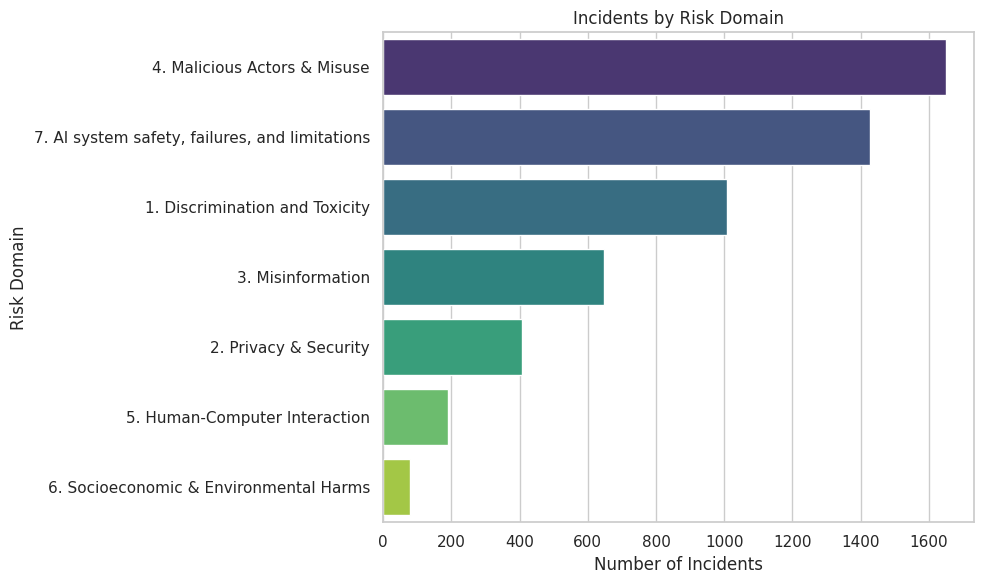

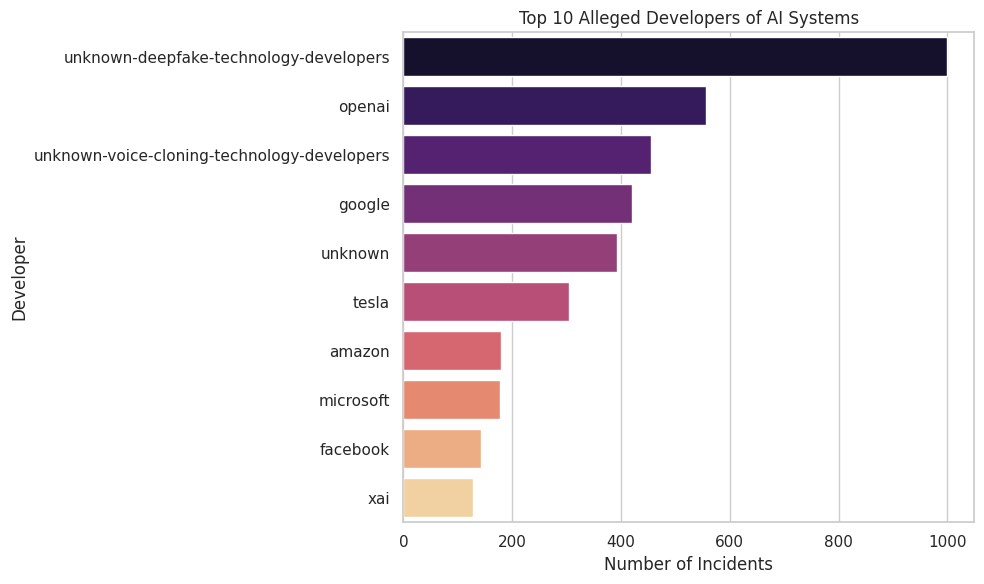

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# 1. Risk Domain Analysis
risk_counts = merged_df['Risk Domain'].value_counts()

plt.figure(figsize=(10, 6))
# Fix: Assign y to hue and set legend=False to avoid FutureWarning
sns.barplot(y=risk_counts.index, x=risk_counts.values, hue=risk_counts.index, palette="viridis", legend=False)
plt.title('Incidents by Risk Domain')
plt.xlabel('Number of Incidents')
plt.ylabel('Risk Domain')
plt.tight_layout()
plt.show()

# 2. Top Alleged Developers Analysis
# Explode the list column to get individual developers
dev_exploded = merged_df.explode('Alleged developer of AI system')

# Count and get top 10
top_devs = dev_exploded['Alleged developer of AI system'].value_counts().head(10)

plt.figure(figsize=(10, 6))
# Fix: Assign y to hue and set legend=False
sns.barplot(y=top_devs.index, x=top_devs.values, hue=top_devs.index, palette="magma", legend=False)
plt.title('Top 10 Alleged Developers of AI Systems')
plt.xlabel('Number of Incidents')
plt.ylabel('Developer')
plt.tight_layout()
plt.show()

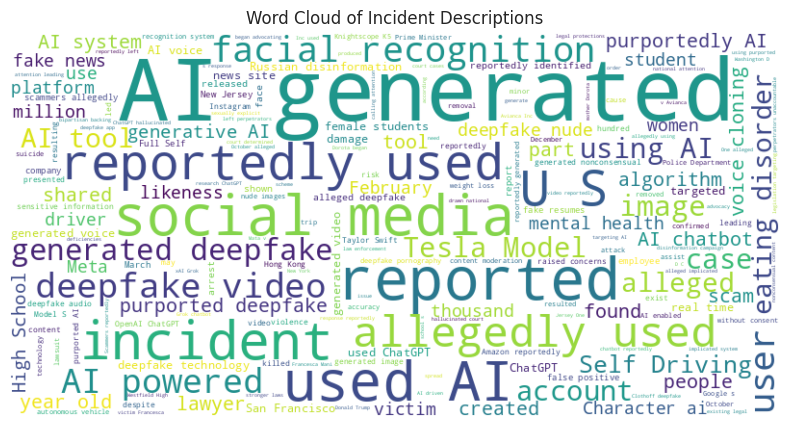

In [78]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. Concatenate all non-null descriptions
text = " ".join(description for description in merged_df.incident_description.dropna())

# 2. Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# 3. Display
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Incident Descriptions')
plt.show()

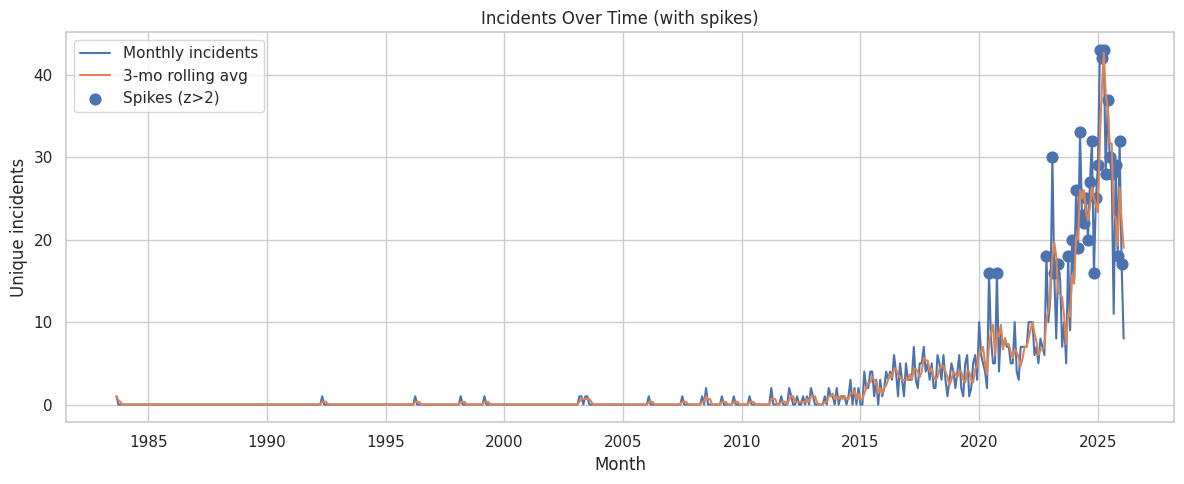

In [79]:
df = merged_df.dropna(subset=["date"]).copy()
ts = df.groupby(pd.Grouper(key="date", freq="MS"))["incident_id"].nunique()

roll = ts.rolling(3, min_periods=1).mean()
z = (ts - ts.mean()) / (ts.std() + 1e-9)
spikes = ts[z > 2]

plt.figure(figsize=(12,5))
plt.plot(ts.index, ts.values, label="Monthly incidents")
plt.plot(roll.index, roll.values, label="3-mo rolling avg")
plt.scatter(spikes.index, spikes.values, s=60, label="Spikes (z>2)")
plt.title("Incidents Over Time (with spikes)")
plt.xlabel("Month")
plt.ylabel("Unique incidents")
plt.legend()
plt.tight_layout()
plt.show()

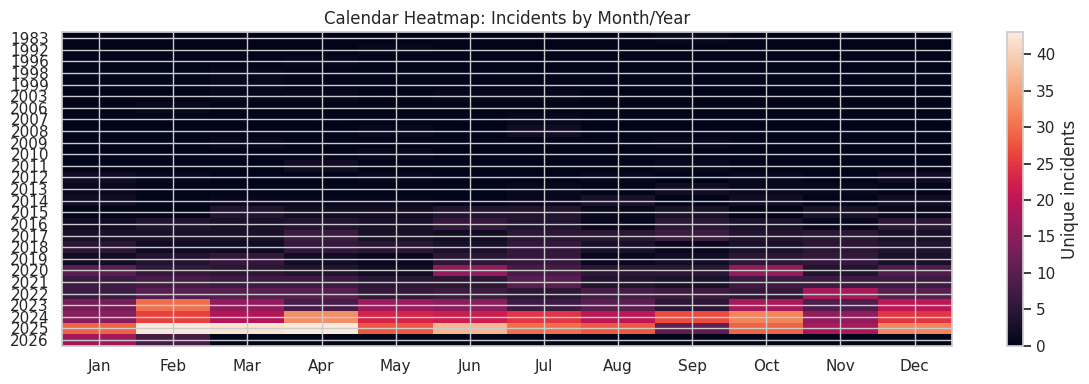

In [80]:
df = merged_df.dropna(subset=["date"]).copy()
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

pivot = df.groupby(["year","month"])["incident_id"].nunique().unstack(fill_value=0)

plt.figure(figsize=(12,4))
plt.imshow(pivot.values, aspect="auto")
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xticks(range(12), ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.colorbar(label="Unique incidents")
plt.title("Calendar Heatmap: Incidents by Month/Year")
plt.tight_layout()
plt.show()

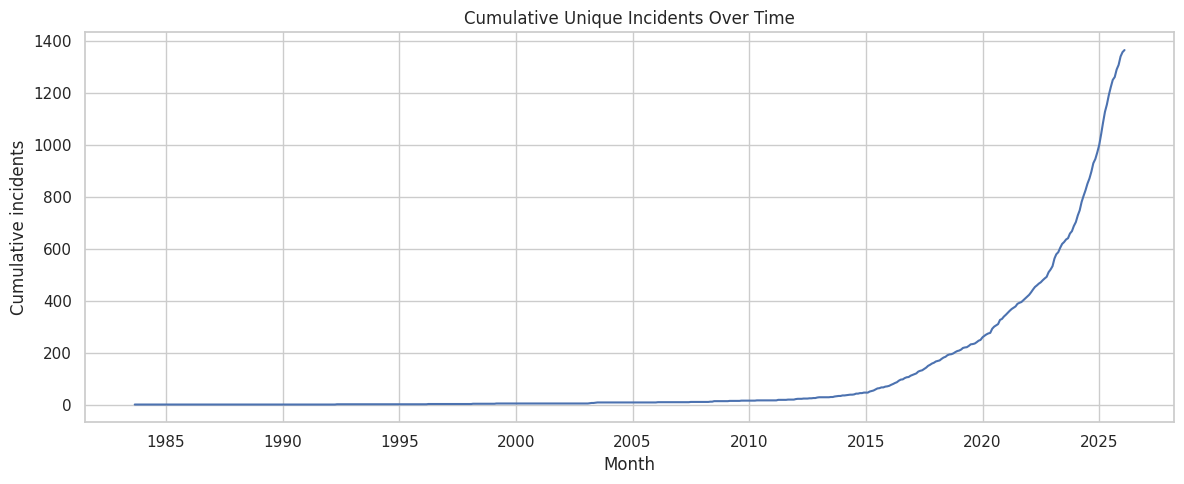

In [81]:
df = merged_df.dropna(subset=["date"]).copy()
ts = df.groupby(pd.Grouper(key="date", freq="MS"))["incident_id"].nunique()
cum = ts.cumsum()

plt.figure(figsize=(12,5))
plt.plot(cum.index, cum.values)
plt.title("Cumulative Unique Incidents Over Time")
plt.xlabel("Month")
plt.ylabel("Cumulative incidents")
plt.tight_layout()
plt.show()

In [82]:
merged_df.to_csv('processed_incidents.csv', index=False)
print("Saved merged_df to 'processed_incidents.csv'.")

Saved merged_df to 'processed_incidents.csv'.


In [102]:
import json
import re
import math
from typing import Any, Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google import genai


# =========================
# JSON-safe conversion
# =========================

def make_json_safe(obj: Any) -> Any:
    """
    Recursively convert pandas/numpy objects into JSON-serializable Python types.
    Fixes issues like: TypeError: Object of type Timestamp is not JSON serializable
    """
    if obj is None:
        return None

    # pandas NaT
    if obj is pd.NaT:
        return None

    # pandas Timestamp
    if isinstance(obj, pd.Timestamp):
        return obj.isoformat()

    # numpy scalar types
    if isinstance(obj, np.integer):
        return int(obj)

    if isinstance(obj, np.floating):
        v = float(obj)
        return None if (math.isnan(v) or math.isinf(v)) else v

    if isinstance(obj, np.bool_):
        return bool(obj)

    # numpy arrays
    if isinstance(obj, np.ndarray):
        return [make_json_safe(x) for x in obj.tolist()]

    # dict/list/tuple
    if isinstance(obj, dict):
        return {str(k): make_json_safe(v) for k, v in obj.items()}

    if isinstance(obj, (list, tuple)):
        return [make_json_safe(x) for x in obj]

    # fall-through for str/int/float/bool, etc.
    return obj


# =========================
# Column matching helpers
# =========================

def _normalize(s: str) -> str:
    return re.sub(r"[^a-z0-9]+", "", str(s).lower().strip())

def _best_col_match(df: pd.DataFrame, candidate_names: List[str]) -> Optional[str]:
    """
    Try to match a semantic column name (platform/region/date/etc.) to an actual df column.
    Uses normalization + contains matching.
    """
    cols = list(df.columns)
    norm_cols = {_normalize(c): c for c in cols}

    # direct normalized match
    for cand in candidate_names:
        nc = _normalize(cand)
        if nc in norm_cols:
            return norm_cols[nc]

    # contains match
    for cand in candidate_names:
        nc = _normalize(cand)
        for ncol, orig in norm_cols.items():
            if nc and (nc in ncol or ncol in nc):
                return orig

    return None


# =========================
# SAFE query plan executor
# =========================

def execute_query_plan(df: pd.DataFrame, plan: Dict[str, Any]) -> Tuple[pd.DataFrame, str]:
    """
    Executes a restricted JSON plan on df.
    Returns (result_df, generated_sql_like_string).

    Allowed plan keys:
      - filters: list of {col, op, value, case_insensitive}
      - select_cols: list[str] or []
      - sort: {col, ascending}
      - limit: int
      - groupby: {by: [cols], agg: [{col, fn, as}]}
    """
    working = df.copy()

    filters = plan.get("filters", []) or []
    where_clauses = []

    for f in filters:
        col = f.get("col")
        op = f.get("op")
        val = f.get("value")
        ci = bool(f.get("case_insensitive", True))

        if not col or col not in working.columns or not op:
            continue

        series = working[col]

        # String-ish operations
        if op in ("contains", "equals", "in"):
            s = series.astype(str)
            if ci:
                s_cmp = s.str.lower()
                if isinstance(val, list):
                    val_cmp = [str(x).lower() for x in val]
                else:
                    val_cmp = str(val).lower()
            else:
                s_cmp = s
                val_cmp = val

            if op == "contains":
                working = working[s_cmp.str.contains(str(val_cmp), na=False)]
                where_clauses.append(f"{col} ILIKE '%{val}%'")
            elif op == "equals":
                working = working[s_cmp == str(val_cmp)]
                where_clauses.append(f"{col} ILIKE '{val}'" if ci else f"{col} = '{val}'")
            elif op == "in":
                if not isinstance(val_cmp, list):
                    val_cmp = [val_cmp]
                working = working[s_cmp.isin(val_cmp)]
                where_clauses.append(f"{col} IN ({', '.join([repr(x) for x in (val or [])])})")

        # Numeric/date comparisons (best effort)
        elif op in ("gt", "gte", "lt", "lte"):
            s_num = pd.to_numeric(series, errors="coerce")
            v_num = pd.to_numeric(pd.Series([val]), errors="coerce").iloc[0]

            if pd.isna(v_num):
                # try datetime
                s_dt = pd.to_datetime(series, errors="coerce")
                v_dt = pd.to_datetime(val, errors="coerce")
                if pd.isna(v_dt):
                    continue

                if op == "gt":
                    working = working[s_dt > v_dt]
                    where_clauses.append(f"{col} > '{val}'")
                elif op == "gte":
                    working = working[s_dt >= v_dt]
                    where_clauses.append(f"{col} >= '{val}'")
                elif op == "lt":
                    working = working[s_dt < v_dt]
                    where_clauses.append(f"{col} < '{val}'")
                elif op == "lte":
                    working = working[s_dt <= v_dt]
                    where_clauses.append(f"{col} <= '{val}'")
            else:
                if op == "gt":
                    working = working[s_num > v_num]
                    where_clauses.append(f"{col} > {val}")
                elif op == "gte":
                    working = working[s_num >= v_num]
                    where_clauses.append(f"{col} >= {val}")
                elif op == "lt":
                    working = working[s_num < v_num]
                    where_clauses.append(f"{col} < {val}")
                elif op == "lte":
                    working = working[s_num <= v_num]
                    where_clauses.append(f"{col} <= {val}")

    # Groupby + Agg
    groupby = plan.get("groupby")
    sql_select_parts = []

    if isinstance(groupby, dict):
        by_cols = [c for c in (groupby.get("by") or []) if c in working.columns]
        aggs = groupby.get("agg") or []

        agg_map = {}
        for a in aggs:
            col = a.get("col")
            fn = a.get("fn")
            alias = a.get("as") or f"{fn}_{col}"

            if col in working.columns and fn in ("count", "nunique", "sum", "mean", "max", "min"):
                if fn == "count":
                    agg_map[alias] = (col, "count")
                else:
                    agg_map[alias] = (col, fn)

        if by_cols and agg_map:
            working = working.groupby(by_cols, dropna=False).agg(**agg_map).reset_index()

            sql_select_parts.extend(by_cols)
            for alias, (col, fn) in agg_map.items():
                if fn == "count":
                    sql_select_parts.append(f"COUNT({col}) AS {alias}")
                else:
                    sql_select_parts.append(f"{fn.upper()}({col}) AS {alias}")

    # select columns
    select_cols = plan.get("select_cols") or []
    if select_cols:
        select_cols = [c for c in select_cols if c in working.columns]
        if select_cols:
            working = working[select_cols]

    # sorting
    sort = plan.get("sort")
    order_clause = ""
    if isinstance(sort, dict):
        scol = sort.get("col")
        asc = bool(sort.get("ascending", False))
        if scol in working.columns:
            working = working.sort_values(by=scol, ascending=asc)
            order_clause = f"ORDER BY {scol} {'ASC' if asc else 'DESC'}"

    # limit
    limit = plan.get("limit", 10)
    try:
        limit = int(limit)
    except Exception:
        limit = 10
    if limit > 0:
        working = working.head(limit)

    sql_select = ", ".join(sql_select_parts) if sql_select_parts else (
        ", ".join(select_cols) if select_cols else "*"
    )
    sql_where = ("WHERE " + " AND ".join(where_clauses)) if where_clauses else ""
    sql_limit = f"LIMIT {limit}" if limit else ""
    sql_like = f"SELECT {sql_select} FROM merged_df {sql_where} {order_clause} {sql_limit}".strip()

    return working, sql_like


# =========================
# Gemini planner
# =========================

def _extract_json(text: str) -> Dict[str, Any]:
    text = (text or "").strip()

    # pure JSON case
    if text.startswith("{") and text.endswith("}"):
        return json.loads(text)

    # find first JSON object
    m = re.search(r"\{.*\}", text, flags=re.DOTALL)
    if not m:
        raise ValueError("No JSON found in Gemini output.")
    return json.loads(m.group(0))


def plan_query_with_gemini(
    user_query: str,
    api_key: str,
    df: pd.DataFrame,
    model: str = "gemini-2.5-flash",
) -> Dict[str, Any]:
    client = genai.Client(api_key=api_key)

    cols = df.columns.tolist()
    sample_rows = make_json_safe(df.head(5).to_dict(orient="records"))

    semantic_hints = {
        "platform": _best_col_match(df, ["platform", "system", "application", "product", "source", "site", "service"]),
        "region": _best_col_match(df, ["region", "country", "continent", "location", "jurisdiction", "market"]),
        "date": _best_col_match(df, ["date", "incident_date", "reported_date", "created_at", "timestamp", "year"]),
        "severity": _best_col_match(df, ["severity", "priority", "risk", "impact", "level"]),
        "category": _best_col_match(df, ["category", "type", "taxonomy", "incident_type", "topic"]),
        "status": _best_col_match(df, ["status", "active", "state", "resolved"]),
        "title": _best_col_match(df, ["title", "summary", "description", "incident"]),
    }

    system_instructions = """
You are a data query planner. You will receive:
- a pandas DataFrame named merged_df (columns provided)
- a user’s policy-oriented question

Your job: output a JSON query plan ONLY, matching this schema:

{
  "intent": "retrieve_examples" | "trend" | "breakdown" | "kpi",
  "filters": [
    {"col": "<exact df column>", "op": "contains|equals|in|gt|gte|lt|lte", "value": "<string|number|list>", "case_insensitive": true}
  ],
  "groupby": {
    "by": ["<col1>", "<col2>"],
    "agg": [{"col":"<col>", "fn":"count|nunique|sum|mean|max|min", "as":"<alias>"}]
  },
  "select_cols": ["<col>", "..."],
  "sort": {"col":"<col>", "ascending": false},
  "limit": 10,
  "notes": "<1 short sentence explaining what you’re returning>"
}

Rules:
- Use only columns that exist in the provided columns list.
- Prefer practical outputs for policy work: top incidents, breakdown by category, severity distribution, recent incidents.
- If the user mentions a platform (e.g., YouTube), filter using the best matching column (platform/title/description).
- If the user mentions region (e.g., North America), filter using the best matching location/jurisdiction column.
- If no exact region column exists, approximate by filtering country in ["United States", "Canada", "Mexico"] if a country column exists.
- Keep it simple: 1 query plan, limit 10 by default.
Output JSON only. No markdown.
""".strip()

    payload = make_json_safe({
        "columns": cols,
        "semantic_hints": semantic_hints,
        "sample_rows": sample_rows,
        "user_query": user_query,
    })

    resp = client.models.generate_content(
        model=model,
        contents=[system_instructions, json.dumps(payload)],
    )

    plan = _extract_json(resp.text)
    return plan


# =========================
# Main assistant function
# =========================

def policy_data_assistant(
    user_query: str,
    api_key: str,
    merged_df: pd.DataFrame,
    model: str = "gemini-2.5-flash",
) -> Dict[str, Any]:
    """
    End-to-end:
      1) Gemini produces a JSON query plan
      2) We execute it safely on merged_df (no eval)
      3) Return plan + SQL-like string + result df
    """
    plan = plan_query_with_gemini(user_query, api_key, merged_df, model=model)
    result_df, sql_like = execute_query_plan(merged_df, plan)

    return {
        "query_plan": plan,
        "sql_like": sql_like,
        "result": result_df,
    }

In [104]:
out = policy_data_assistant(
    user_query="which incidents have the maximum reports under it?",
    api_key="",
    merged_df=merged_df
)

print(out["sql_like"])
display(out["result"].head(10))
print(out["query_plan"]["notes"])

SELECT incident_id, incident_title, COUNT(report_number) AS report_count FROM merged_df  ORDER BY report_count DESC LIMIT 10


,incident_id,incident_title,report_count
530,541,ChatGPT Reportedly Produced False Court Case L...,58
585,597,Female Students at Westfield High School in Ne...,57
533,545,Chatbot Tessa gives unauthorized diet advice t...,46
604,616,Sports Illustrated Is Alleged to Have Used AI ...,43
1106,1118,Ongoing Purported AI-Assisted Identity Fraud E...,41
56,57,Australian Automated Debt Assessment System Is...,39
689,701,American Asylum Seeker John Mark Dougan in Rus...,36
814,826,Character.ai Chatbot Allegedly Influenced Teen...,36
33,34,Amazon Alexa Responding to Environmental Inputs,35
633,645,Seeming Pattern of Gemini Bias and Sociotechni...,35


Returns incidents with the highest number of associated reports.


In [109]:
out = policy_data_assistant(
    user_query="help me provide data for building a policy on risk domain like overreliance and unsafe use",
    api_key="",
    merged_df=merged_df
)

print(out["sql_like"])
display(out["result"].head(10))
print(out["query_plan"]["notes"])

SELECT Risk Domain, NUNIQUE(incident_id) AS number_of_incidents FROM merged_df  ORDER BY number_of_incidents DESC LIMIT 10


,Risk Domain,number_of_incidents
3,4. Malicious Actors & Misuse,424
6,"7. AI system safety, failures, and limitations",282
0,1. Discrimination and Toxicity,230
2,3. Misinformation,159
7,NaN,125
1,2. Privacy & Security,95
4,5. Human-Computer Interaction,33
5,6. Socioeconomic & Environmental Harms,19


Breakdown of incidents by their primary risk domain, showing the most frequent types.
